In [1]:
import pandas as pd
import numpy as np
import json
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import keras_tuner as kt

2025-04-12 18:39:23.144021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-12 18:39:23.222623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-12 18:39:23.246221: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-12 18:39:23.398661: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check for GPU
print("GPU available:", tf.config.list_physical_devices('GPU'))

# ======= Data Loading and Preprocessing =======
def load_data(file_path):
    """Load JSON lines data"""
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

# Access the file path
file_path = "/mnt/c/Users/muham/Documents/Documents/Tugas Kuliah/Tugas Kuliah Semester 6/Deep-Learning/Week 6/DeteksiSarkasme.json"

data = load_data(file_path)
print(f"\nLoaded {len(data)} examples from {file_path}")

# Display some statistics
print(f"Data Distribution:")
print(data['is_sarcastic'].value_counts())
print("\nExample sarcastic headline:")
print(data[data['is_sarcastic'] == 1]['headline'].iloc[0])
print("\nExample non-sarcastic headline:")
print(data[data['is_sarcastic'] == 0]['headline'].iloc[0])

# ======= Text Preprocessing =======
def preprocess_text(text):
    """Clean and normalize text data"""
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply preprocessing to headlines
data['processed_headline'] = data['headline'].apply(preprocess_text)

# ======= Tokenization and Sequence Creation =======
# Maximum number of words to keep in the vocabulary
max_words = 10000

# Maximum sequence length
maxlen = 50

# Create tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token='<UNK>')
tokenizer.fit_on_texts(data['processed_headline'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data['processed_headline'])

# Pad sequences to ensure consistent length
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post')

# Get vocabulary size (add 1 for the 0 padding token)
vocab_size = min(max_words, len(tokenizer.word_index) + 1)
print(f"\nVocabulary size: {vocab_size}")

# ======= Data Preparation =======
# Extract features and labels
X = padded_sequences
y = np.array(data['is_sarcastic'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

I0000 00:00:1744457970.092893   65606 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1744457970.855729   65606 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1744457970.855835   65606 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Loaded 26709 examples from /mnt/c/Users/muham/Documents/Documents/Tugas Kuliah/Tugas Kuliah Semester 6/Deep-Learning/Week 6/DeteksiSarkasme.json
Data Distribution:
is_sarcastic
0    14985
1    11724
Name: count, dtype: int64

Example sarcastic headline:
mom starting to fear son's web series closest thing she will have to grandchild

Example non-sarcastic headline:
former versace store clerk sues over secret 'black code' for minority shoppers

Vocabulary size: 10000
Training set size: 21367
Test set size: 5342


# RNN Model

Trial 30 Complete [00h 02m 13s]
val_accuracy: 0.7533925771713257

Best val_accuracy So Far: 0.8434721827507019
Total elapsed time: 00h 41m 37s
Best Hyperparameters:
- Embedding Dimension: 480
- RNN Units: 64
- Dense Units: 80
- Dropout Rate: 0.2
- Learning Rate: 0.00025314504862623767
Epoch 1/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 0.6633 - loss: 0.5966 - val_accuracy: 0.8292 - val_loss: 0.4089
Epoch 2/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.8655 - loss: 0.3329 - val_accuracy: 0.8393 - val_loss: 0.4026
Epoch 3/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.9303 - loss: 0.1946 - val_accuracy: 0.8252 - val_loss: 0.4802
Epoch 4/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.9484 - loss: 0.1482 - val_accuracy: 0.8297 - val_loss: 0.5343
Epoch 5/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9539 - loss: 0.1280 - val_accuracy: 0.8339 - val_loss: 0.6003
Epoch 6/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy

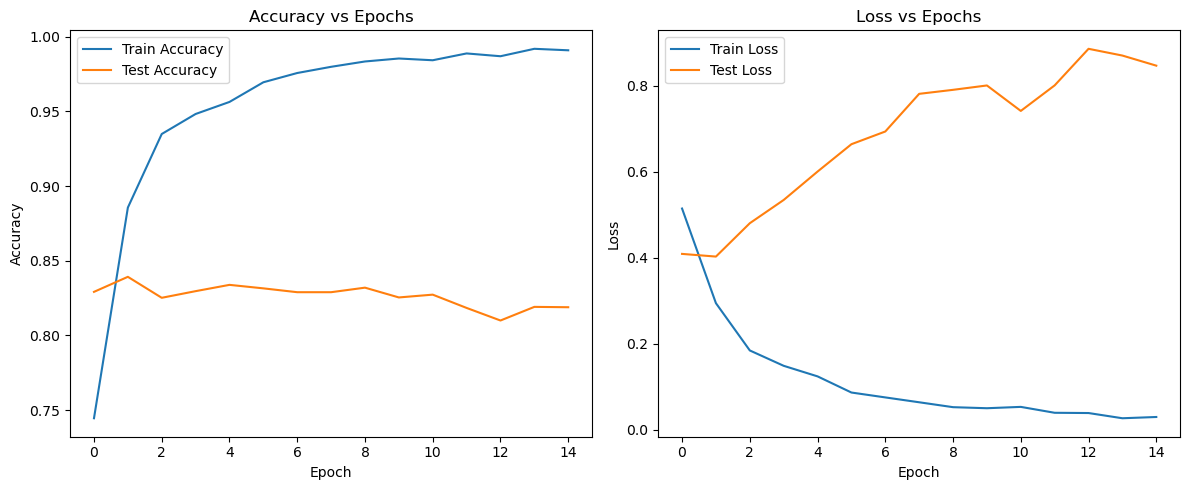

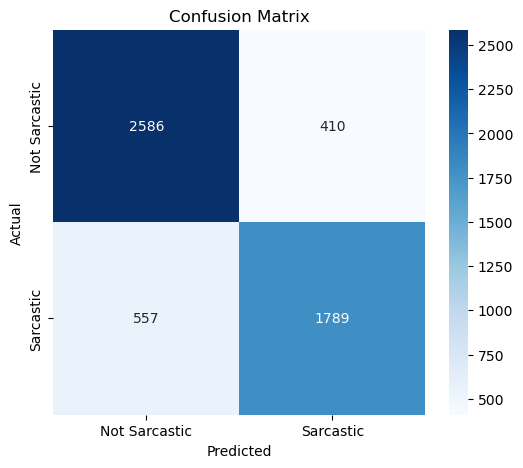

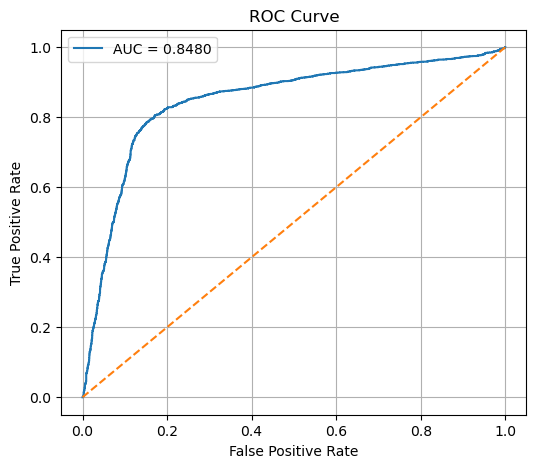

In [3]:
# ======= Model Building with Keras Tuner =======
def build_model(hp):
    """Build a model with hyperparameters to be tuned"""
    model = keras.Sequential()

    # Embedding layer
    embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=1024, step=32)
    model.add(layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim,
                              input_length=maxlen))

    # Dropout for regularization
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(layers.Dropout(dropout_rate))

    # RNN layer (not bidirectional as specified)
    rnn_units = hp.Int('rnn_units', min_value=32, max_value=1024, step=32)
    model.add(layers.SimpleRNN(rnn_units))

    # Dense layers
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=16, max_value=128, step=16),
        activation='relu'
    ))
    model.add(layers.Dropout(dropout_rate))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# ======= Hyperparameter Tuning =======
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='keras_tuner',
    project_name='sarcasm_detection'
)

stop_early = EarlyStopping(monitor='val_accuracy', patience=3)

# Search for the best hyperparameters
tuner.search(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"- Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"- RNN Units: {best_hps.get('rnn_units')}")
print(f"- Dense Units: {best_hps.get('dense_units')}")
print(f"- Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"- Learning Rate: {best_hps.get('learning_rate')}")

# ======= Build and Train the Best Model =======
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model
history = best_model.fit(
    X_train, y_train,
    epochs=15,
    validation_split=0.2,
    verbose=1
)

# Save the tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# ======= Evaluate the model =======
# Get predictions
y_prob = best_model.predict(X_test).flatten()
y_pred = (y_prob >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ======= Visualization =======
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Function to make predictions on new text
def predict_sarcasm(text, model, tokenizer, maxlen):
    """
    Make sarcasm prediction on a text input using TensorFlow model

    Args:
        text: Input text string to classify
        model: Trained TensorFlow model
        tokenizer: Fitted tokenizer
        maxlen: Maximum sequence length

    Returns:
        Dictionary with prediction results
    """
    # Preprocess text
    processed_text = preprocess_text(text)

    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([processed_text])

    # Pad sequence
    padded = pad_sequences(sequence, maxlen=maxlen, padding='post')

    # Make prediction
    probability = model.predict(padded)[0][0]
    is_sarcastic = probability >= 0.5

    return {
        'probability': float(probability),
        'is_sarcastic': bool(is_sarcastic),
        'prediction': "Sarcastic" if is_sarcastic else "Not Sarcastic"
    }

# Example usage
test_examples = [
    "This is absolutely the best day of my life!",
    "I love waiting in line at the DMV.",
    "The weather is beautiful today.",
    "Oh great, another meeting that could have been an email."
]

print("\nPredictions on sample texts:")
for text in test_examples:
    result = predict_sarcasm(text, best_model, tokenizer, maxlen)
    print(f"Text: '{text}'")
    print(f"Prediction: {result['prediction']} (Probability: {result['probability']:.4f})")
    print("-" * 50)


Predictions on sample texts:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
Text: 'This is absolutely the best day of my life!'
Prediction: Not Sarcastic (Probability: 0.0007)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Text: 'I love waiting in line at the DMV.'
Prediction: Not Sarcastic (Probability: 0.0066)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Text: 'The weather is beautiful today.'
Prediction: Not Sarcastic (Probability: 0.0073)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Text: 'Oh great, another meeting that could have been an email.'
Prediction: Sarcastic (Probability: 0.9794)
--------------------------------------------------


# LSTM Model

I0000 00:00:1744457972.508294   65606 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1744457972.508481   65606 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1744457972.508543   65606 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1744457972.931180   65606 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1744457972.931300   65606 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-12

Reloading Tuner from keras_tuner_lstm/sarcasm_detection_lstm/tuner0.json
Best Hyperparameters:
- Embedding Dimension: 704
- LSTM Units: 992
- Dense Units: 48
- Dropout Rate: 0.2
- Learning Rate: 0.001924799181568546
Epoch 1/15


/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-12 18:39:40.623237: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


535/535 ━━━━━━━━━━━━━━━━━━━━ 45s 70ms/step - accuracy: 0.5300 - loss: 0.7177 - val_accuracy: 0.6572 - val_loss: 0.6390
Epoch 2/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 35s 66ms/step - accuracy: 0.6732 - loss: 0.6145 - val_accuracy: 0.7340 - val_loss: 0.6027
Epoch 3/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 35s 65ms/step - accuracy: 0.8000 - loss: 0.4840 - val_accuracy: 0.7794 - val_loss: 0.5214
Epoch 4/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 35s 65ms/step - accuracy: 0.8682 - loss: 0.3673 - val_accuracy: 0.7901 - val_loss: 0.5266
Epoch 5/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 35s 65ms/step - accuracy: 0.8595 - loss: 0.3604 - val_accuracy: 0.7171 - val_loss: 0.5824
Epoch 6/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 35s 66ms/step - accuracy: 0.7815 - loss: 0.4293 - val_accuracy: 0.7110 - val_loss: 0.6058
Epoch 7/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 36s 67ms/step - accuracy: 0.7975 - loss: 0.3973 - val_accuracy: 0.8264 - val_loss: 0.4955
Epoch 8/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step - accuracy: 0.9117 - loss: 0.2450 - val_accurac

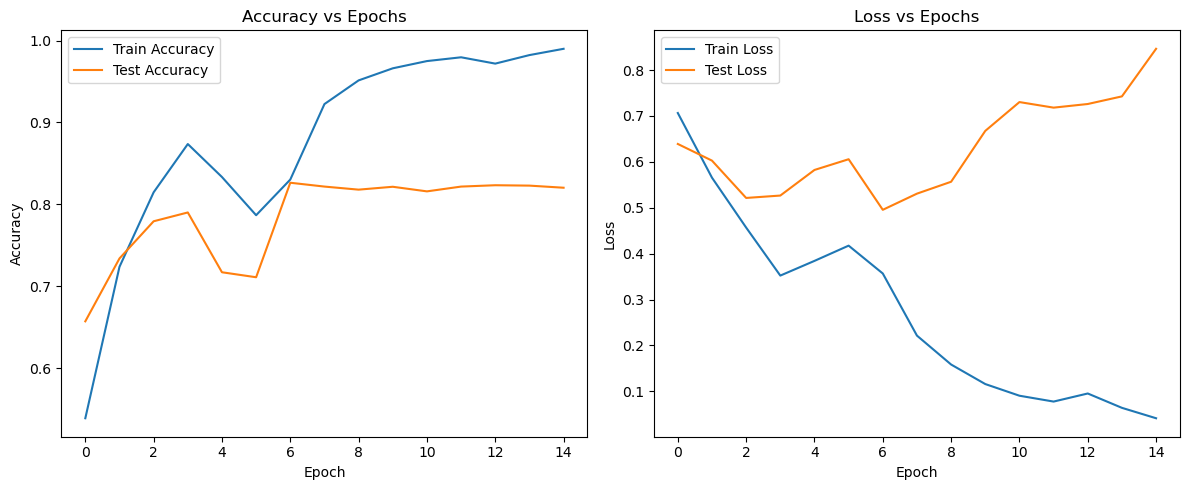

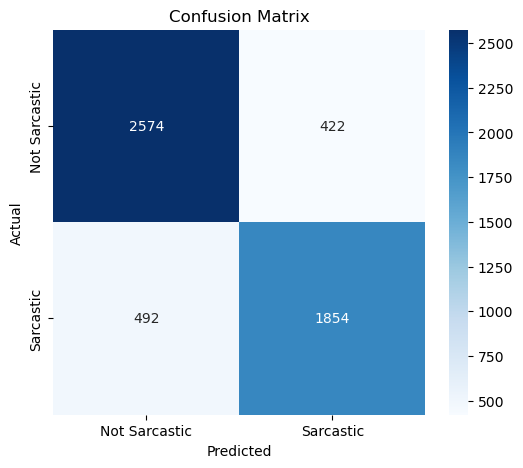

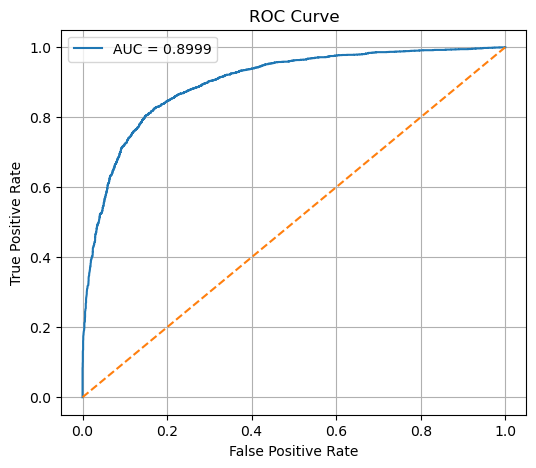

In [3]:
# ======= Model Building with Keras Tuner =======
def build_model(hp):
    """Build a model with hyperparameters to be tuned"""
    model = keras.Sequential()

    # Embedding layer
    embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=1024, step=32)
    model.add(layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim,
                              input_length=maxlen))

    # Dropout for regularization
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(layers.Dropout(dropout_rate))

    # LSTM layer (not bidirectional as specified)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=1024, step=32)
    model.add(layers.LSTM(lstm_units, activation='tanh'))

    # Dense layers
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=16, max_value=128, step=16),
        activation='tanh'
    ))
    model.add(layers.Dropout(dropout_rate))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# ======= Hyperparameter Tuning =======
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='keras_tuner_lstm',
    project_name='sarcasm_detection_lstm'
)

stop_early = EarlyStopping(monitor='val_accuracy', patience=3)

# Search for the best hyperparameters
tuner.search(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"- Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"- LSTM Units: {best_hps.get('lstm_units')}")
print(f"- Dense Units: {best_hps.get('dense_units')}")
print(f"- Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"- Learning Rate: {best_hps.get('learning_rate')}")

# ======= Build and Train the Best Model =======
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model
history = best_model.fit(
    X_train, y_train,
    epochs=15,
    validation_split=0.2,
    verbose=1
)

# Save the tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# ======= Evaluate the model =======
# Get predictions
y_prob = best_model.predict(X_test).flatten()
y_pred = (y_prob >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ======= Visualization =======
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Function to make predictions on new text
def predict_sarcasm(text, model, tokenizer, maxlen):
    """
    Make sarcasm prediction on a text input using TensorFlow model

    Args:
        text: Input text string to classify
        model: Trained TensorFlow model
        tokenizer: Fitted tokenizer
        maxlen: Maximum sequence length

    Returns:
        Dictionary with prediction results
    """
    # Preprocess text
    processed_text = preprocess_text(text)

    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([processed_text])

    # Pad sequence
    padded = pad_sequences(sequence, maxlen=maxlen, padding='post')

    # Make prediction
    probability = model.predict(padded)[0][0]
    is_sarcastic = probability >= 0.5

    return {
        'probability': float(probability),
        'is_sarcastic': bool(is_sarcastic),
        'prediction': "Sarcastic" if is_sarcastic else "Not Sarcastic"
    }

# Example usage
test_examples = [
    "This is absolutely the best day of my life!",
    "I love waiting in line at the DMV.",
    "The weather is beautiful today.",
    "Oh great, another meeting that could have been an email."
]

print("\nPredictions on sample texts:")
for text in test_examples:
    result = predict_sarcasm(text, best_model, tokenizer, maxlen)
    print(f"Text: '{text}'")
    print(f"Prediction: {result['prediction']} (Probability: {result['probability']:.4f})")
    print("-" * 50)


Predictions on sample texts:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Text: 'This is absolutely the best day of my life!'
Prediction: Not Sarcastic (Probability: 0.0024)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Text: 'I love waiting in line at the DMV.'
Prediction: Not Sarcastic (Probability: 0.0025)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Text: 'The weather is beautiful today.'
Prediction: Not Sarcastic (Probability: 0.0024)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Text: 'Oh great, another meeting that could have been an email.'
Prediction: Sarcastic (Probability: 0.8138)
--------------------------------------------------


# GRU Model

Reloading Tuner from keras_tuner_gru/sarcasm_detection_gru/tuner0.json
Best Hyperparameters:
- Embedding Dimension: 672
- GRU Units: 960
- Dense Units: 32
- Dropout Rate: 0.4
- Learning Rate: 0.0011674312709210404
Epoch 1/15


/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


535/535 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - accuracy: 0.5376 - loss: 0.6983 - val_accuracy: 0.5538 - val_loss: 0.6875
Epoch 2/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - accuracy: 0.5519 - loss: 0.6879 - val_accuracy: 0.5538 - val_loss: 0.6875
Epoch 3/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - accuracy: 0.5549 - loss: 0.6886 - val_accuracy: 0.5538 - val_loss: 0.6864
Epoch 4/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - accuracy: 0.5882 - loss: 0.6830 - val_accuracy: 0.7284 - val_loss: 0.5601
Epoch 5/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - accuracy: 0.7820 - loss: 0.5041 - val_accuracy: 0.7803 - val_loss: 0.4708
Epoch 6/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - accuracy: 0.8274 - loss: 0.4014 - val_accuracy: 0.8154 - val_loss: 0.4185
Epoch 7/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - accuracy: 0.8640 - loss: 0.3372 - val_accuracy: 0.8191 - val_loss: 0.4400
Epoch 8/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - accuracy: 0.9013 - loss: 0.2618 - val_accurac

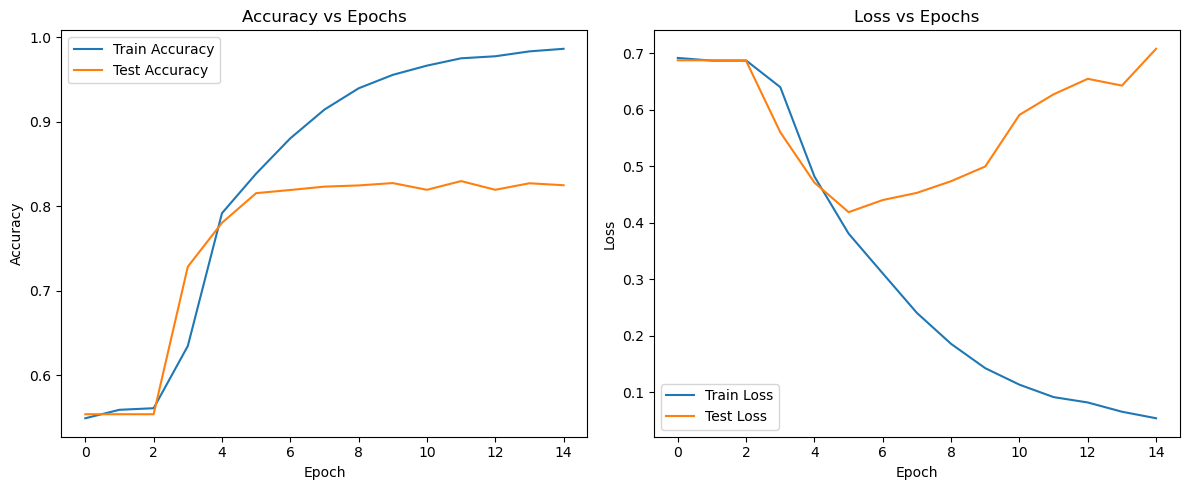

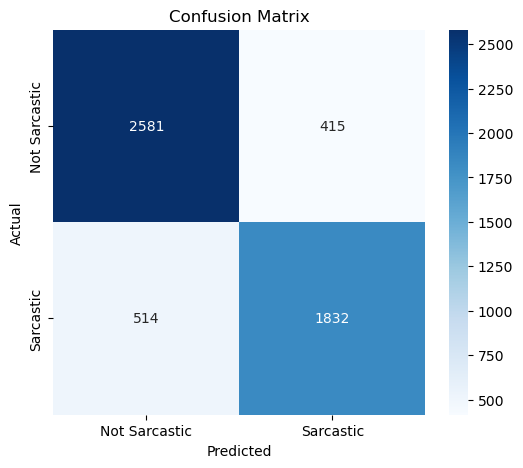

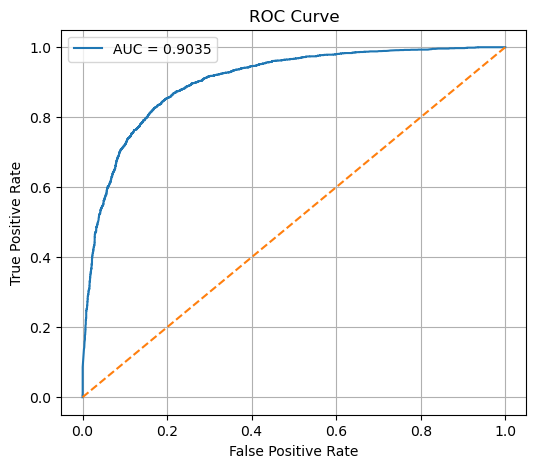

In [8]:
# ======= Model Building with Keras Tuner =======
def build_model(hp):
    """Build a model with hyperparameters to be tuned"""
    model = keras.Sequential()

    # Embedding layer
    embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=1024, step=32)
    model.add(layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim,
                              input_length=maxlen))

    # Dropout for regularization
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    model.add(layers.Dropout(dropout_rate))

    # LSTM layer (not bidirectional as specified)
    gru_units = hp.Int('gru_units', min_value=32, max_value=1024, step=32)
    model.add(layers.GRU(gru_units, activation='tanh'))

    # Dense layers
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=16, max_value=128, step=16),
        activation='tanh'
    ))
    model.add(layers.Dropout(dropout_rate))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# ======= Hyperparameter Tuning =======
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='keras_tuner_gru',
    project_name='sarcasm_detection_gru'
)

stop_early = EarlyStopping(monitor='val_accuracy', patience=3)

# Search for the best hyperparameters
tuner.search(
    X_train, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"- Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"- GRU Units: {best_hps.get('gru_units')}")
print(f"- Dense Units: {best_hps.get('dense_units')}")
print(f"- Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"- Learning Rate: {best_hps.get('learning_rate')}")

# ======= Build and Train the Best Model =======
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model
history = best_model.fit(
    X_train, y_train,
    epochs=15,
    validation_split=0.2,
    verbose=1
)

# Save the tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# ======= Evaluate the model =======
# Get predictions
y_prob = best_model.predict(X_test).flatten()
y_pred = (y_prob >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ======= Visualization =======
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Function to make predictions on new text
def predict_sarcasm(text, model, tokenizer, maxlen):
    """
    Make sarcasm prediction on a text input using TensorFlow model

    Args:
        text: Input text string to classify
        model: Trained TensorFlow model
        tokenizer: Fitted tokenizer
        maxlen: Maximum sequence length

    Returns:
        Dictionary with prediction results
    """
    # Preprocess text
    processed_text = preprocess_text(text)

    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([processed_text])

    # Pad sequence
    padded = pad_sequences(sequence, maxlen=maxlen, padding='post')

    # Make prediction
    probability = model.predict(padded)[0][0]
    is_sarcastic = probability >= 0.5

    return {
        'probability': float(probability),
        'is_sarcastic': bool(is_sarcastic),
        'prediction': "Sarcastic" if is_sarcastic else "Not Sarcastic"
    }

# Example usage
test_examples = [
    "This is absolutely the best day of my life!",
    "I love waiting in line at the DMV.",
    "The weather is beautiful today.",
    "Oh great, another meeting that could have been an email."
]

print("\nPredictions on sample texts:")
for text in test_examples:
    result = predict_sarcasm(text, best_model, tokenizer, maxlen)
    print(f"Text: '{text}'")
    print(f"Prediction: {result['prediction']} (Probability: {result['probability']:.4f})")
    print("-" * 50)


Predictions on sample texts:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Text: 'This is absolutely the best day of my life!'
Prediction: Not Sarcastic (Probability: 0.0030)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Text: 'I love waiting in line at the DMV.'
Prediction: Not Sarcastic (Probability: 0.0030)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Text: 'The weather is beautiful today.'
Prediction: Not Sarcastic (Probability: 0.0030)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Text: 'Oh great, another meeting that could have been an email.'
Prediction: Not Sarcastic (Probability: 0.0031)
--------------------------------------------------


# Penjelasan Model, Visualisasi, dan Metrik

## 1. RNN (Recurrent Neural Network)

RNN menggunakan mekanisme **recurrence** untuk mengolah data urut seperti teks atau waktu. Formula utama yang digunakan dalam RNN adalah:

### Persamaan Dasar:
- **State Update**:
  $$
  h_t = f(W_h \cdot h_{t-1} + W_x \cdot x_t + b)
  $$
  - **Penjelasan**:
    - \($h_t$\): State tersembunyi pada waktu \(t\).
    - \($x_t$\): Input saat waktu \(t\).
    - \($W_h$\), \($W_x$\): Matriks bobot untuk state sebelumnya dan input saat ini.
    - \($b$\): Bias.
    - \($f$\): Fungsi aktivasi (contoh: tanh atau ReLU).

### Alur:
Pada setiap langkah waktu, RNN memperbarui state tersembunyi \($h_t$\) menggunakan input saat itu \($x_t$\) dan state sebelumnya \($h_{t-1}$\).

---

## 2. LSTM (Long Short-Term Memory)

LSTM mengatasi masalah **vanishing gradient** yang sering dialami RNN dengan menggunakan **gate mechanism**.

### Persamaan Dasar:
1. **Forget Gate**:
   $$
   f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
   $$
   - **Fungsi**: Memutuskan informasi mana yang harus dibuang dari memori.

2. **Input Gate**:
   $$
   i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
   $$
   $$
   \tilde{C}_t = \text{tanh}(W_C \cdot [h_{t-1}, x_t] + b_C)
   $$
   - **Fungsi**: Menghitung memori baru yang akan ditambahkan.

3. **Cell State Update**:
   $$
   C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
   $$
   - **Fungsi**: Memperbarui state sel.

4. **Output Gate**:
   $$
   o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
   $$
   $$
   h_t = o_t \cdot \text{tanh}(C_t)
   $$
   - **Fungsi**: Menghitung keluaran berdasarkan state sel yang diperbarui.

---

## 3. GRU (Gated Recurrent Unit)

GRU adalah versi sederhana dari LSTM tanpa cell state terpisah. Persamaan yang digunakan:

### Persamaan Dasar:
1. **Reset Gate**:
   $$
   r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)
   $$
   - **Fungsi**: Memutuskan informasi masa lalu yang harus dilupakan.

2. **Update Gate**:
   $$
   z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)
   $$
   - **Fungsi**: Mengontrol berapa banyak informasi dari masa lalu yang akan dibawa ke state saat ini.

3. **State Update**:
   $$
   \tilde{h}_t = \text{tanh}(W_h \cdot [r_t \odot h_{t-1}, x_t] + b_h)
   $$
   $$
   h_t = (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h}_t
   $$
   - **Fungsi**: State tersembunyi diperbarui menggunakan reset dan update gate.

---

## 4. Visualisasi

### Akurasi:
Akurasi dihitung sebagai:
$$
\text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Sampel}}
$$

### Loss:
Loss dalam pelatihan model dihitung menggunakan fungsi **Binary Cross Entropy (BCE)**:
$$
\text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^{N} \big[y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i)\big]
$$
- \($y_i$\): Label sebenarnya.
- \($\hat{y}_i$\): Probabilitas prediksi model.

### ROC Curve:
ROC Curve menunjukkan hubungan antara **True Positive Rate (TPR)** dan **False Positive Rate (FPR)**:
- **TPR**:
  $$
  TPR = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$
- **FPR**:
  $$
  FPR = \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}}
  $$

### AUC (Area Under Curve):
AUC mengukur area di bawah ROC Curve:
$$
\text{AUC} = \int_{0}^{1} TPR(FPR) \,dFPR
$$
Nilai AUC berkisar antara 0 hingga 1, dengan 1 menunjukkan prediksi sempurna.

---

## 5. Metrik

### Precision:
Precision mengukur seberapa tepat model dalam prediksi kelas positif:
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

### Recall:
Recall mengukur kemampuan model untuk mendeteksi semua kelas positif:
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

### F1 Score:
F1 Score adalah rata-rata harmonis antara precision dan recall:
$$
\text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

---

# Penjelasan Matematika PyTorch

## 1. Embedding Layer
Layer **`nn.Embedding`** digunakan untuk mengubah input indeks menjadi representasi vektor yang dapat dipelajari:
$$
E(x_t) = W_{embedding} \cdot x_t
$$
- **Dimensi**:
  - \($x_t$\): Input berupa indeks kata, dengan dimensi \($(batch\_size, sequence\_length)$\).
  - \($W_{embedding}$\): Matriks bobot dengan ukuran \($(\text{vocab\_size}, \text{embed\_dim})$\).
  - Output: Tensor dengan dimensi \($(batch\_size, sequence\_length, \text{embed\_dim})$\).

PyTorch secara otomatis memperbarui \($W_{embedding}$\) selama pelatihan untuk menghasilkan representasi kata yang bermakna.

---

## 2. RNN, GRU, dan LSTM
### **a. RNN (`nn.RNN`)**
Recurrent Neural Network (RNN) digunakan untuk memproses data sekuensial. Persamaan matematisnya adalah:
$$
h_t = \text{tanh}(W_{ih} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)
$$
- \($h_t$\): State tersembunyi pada waktu \($t$\).
- \($W_{ih}$\): Bobot input ke hidden state (\($\text{input\_dim}$ $\to$ $\text{hidden\_dim}$\)).
- \($W_{hh}$\): Bobot antara hidden state (\($\text{hidden\_dim}$ $\to$ $\text{hidden\_dim}$\)).
- \($b_h$\): Bias.
- Fungsi aktivasi: **tanh**.

Output RNN adalah state tersembunyi pada setiap langkah waktu.

---

### **b. GRU (`nn.GRU`)**
GRU menggunakan mekanisme gate untuk menangani vanishing gradient:
1. **Reset Gate**:
   $$
   r_t = \sigma(W_{ir} \cdot x_t + W_{hr} \cdot h_{t-1} + b_r)
   $$
   - Mengontrol seberapa banyak informasi masa lalu yang dilupakan.
2. **Update Gate**:
   $$
   z_t = \sigma(W_{iz} \cdot x_t + W_{hz} \cdot h_{t-1} + b_z)
   $$
   - Mengontrol informasi baru yang ditambahkan ke state.
3. **State Update**:
   $$
   \tilde{h}_t = \text{tanh}(W_{ih} \cdot x_t + W_{hh} \cdot (r_t \odot h_{t-1}) + b_h)
   $$
   $$
   h_t = (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h}_t
   $$

PyTorch menangani semua kalkulasi ini secara otomatis dalam layer GRU.

---

### **c. LSTM (`nn.LSTM`)**
LSTM memiliki struktur yang lebih kompleks dibanding GRU, dengan 3 jenis gate:
1. **Forget Gate**:
   $$
   f_t = \sigma(W_{if} \cdot x_t + W_{hf} \cdot h_{t-1} + b_f)
   $$
2. **Input Gate**:
   $$
   i_t = \sigma(W_{ii} \cdot x_t + W_{hi} \cdot h_{t-1} + b_i)
   $$
   $$
   \tilde{C}_t = \text{tanh}(W_{ic} \cdot x_t + W_{hc} \cdot h_{t-1} + b_c)
   $$
3. **Output Gate**:
   $$
   o_t = \sigma(W_{io} \cdot x_t + W_{ho} \cdot h_{t-1} + b_o)
   $$
4. **State Update**:
   $$
   C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
   $$
   $$
   h_t = o_t \cdot \text{tanh}(C_t)
   $$

Di PyTorch, `nn.LSTM` mengelola kedua state (\($h_t$\), \($C_t$\)) secara otomatis.

---

## 3. Dropout (`nn.Dropout`)
Layer `nn.Dropout` digunakan untuk regularisasi. Operasinya dapat dirumuskan sebagai:
$$
d_t = M \cdot h_t
$$
- \($M$\): Mask binari yang dihasilkan dengan probabilitas \($p$\) untuk dropout.

Dropout diaktifkan selama pelatihan (`model.train()`) tetapi tidak diterapkan saat evaluasi (`model.eval()`).

---

## 4. Fully Connected Layers (`nn.Linear`)
Layer `nn.Linear` adalah transformasi linier sederhana:
$$
y_t = W \cdot h_t + b
$$
- \($W$\): Matriks bobot (\($\text{hidden\_dim} \to \text{output\_dim}$\)).
- \($b$\): Bias.

Fungsi aktivasi seperti `ReLU` atau `Sigmoid` diterapkan setelah `nn.Linear` untuk menambahkan non-linearitas.

---

## 5. Binary Cross-Entropy Loss (BCELoss)
Loss dihitung menggunakan rumus:
$$
\text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^{N} \big[y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i)\big]
$$
- \($y_i$\): Label sebenarnya (0 atau 1).
- \($\hat{y}_i$\): Probabilitas prediksi setelah fungsi sigmoid.

---

## 6. GradScaler
PyTorch mendukung precision campuran dengan `torch.amp.GradScaler` untuk mencegah angka terlalu kecil atau besar:
- **Forward Pass**:
  $$ \text{loss} = \text{criterion}(output, label) $$
- **Gradient Scaling**:
  $$ \text{scaled\_loss} = \text{scale} \cdot \text{loss} $$
- Setelah backward pass:
  $$ \text{gradients} = \frac{\partial (\text{scaled\_loss})}{\partial (\text{parameters})} $$

Scaler memperbarui bobot sambil mempertahankan stabilitas numerik.

---

## 7. ReduceLROnPlateau
Scheduler ini mengurangi learning rate berdasarkan stagnasi pada loss validasi:
$$
\text{lr\_new} = \text{lr\_old} \times \text{factor}
$$
Dengan **PyTorch**:
```python
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)
scheduler.step(test_loss)


# Penyesuaian Hyperparameter dengan Keras-Tuner

Keras-Tuner mempermudah proses pencarian hyperparameter terbaik dalam pembangunan model pembelajaran mesin. Dalam kode ini, **Hyperband Tuner** digunakan untuk menemukan konfigurasi hyperparameter terbaik untuk model LSTM. Berikut adalah penjelasan terperinci:

## Algoritma Hyperband
Hyperband secara dinamis mengalokasikan sumber daya pelatihan (seperti jumlah epoch) ke konfigurasi hyperparameter:
- Memulai dengan banyak konfigurasi dengan sedikit epoch.
- Secara bertahap mengalokasikan lebih banyak epoch ke konfigurasi dengan kinerja terbaik untuk efisiensi.

Jumlah uji coba berkurang berdasarkan faktor $ \text{factor} $, sambil menyeimbangkan eksplorasi (mencoba berbagai konfigurasi) dan eksploitasi (fokus pada konfigurasi yang menjanjikan).

Untuk **$ \text{max\_epochs}=10 $** dan **$ \text{factor}=3 $**, jumlah uji coba di setiap tahap pengurangan dihitung sebagai:
$$
n = \frac{\text{max\_epochs}}{\text{factor}}
$$

---

## Hyperparameter yang Disetel
### 1. **Dimensi Embedding**
Menentukan dimensi vektor embedding untuk token input:
- **Rentang**: $ [32, 1024] $
- **Langkah**: $ 32 $

$$
\text{embedding\_dim} \in \{32, 64, 96, \dots, 1024\}
$$

### 2. **Unit LSTM**
Menentukan jumlah unit LSTM pada lapisan rekuren:
- **Rentang**: $ [32, 1024] $
- **Langkah**: $ 32 $

$$
\text{lstm\_units} \in \{32, 64, 96, \dots, 1024\}
$$

### 3. **Unit Dense**
Menentukan jumlah neuron pada lapisan Dense:
- **Rentang**: $ [16, 128] $
- **Langkah**: $ 16 $

$$
\text{dense\_units} \in \{16, 32, 48, \dots, 128\}
$$

### 4. **Tingkat Dropout**
Tingkat dropout untuk regularisasi:
- **Rentang**: $ [0.1, 0.5] $
- **Langkah**: $ 0.1 $

$$
\text{dropout\_rate} \in \{0.1, 0.2, 0.3, \dots, 0.5\}
$$

### 5. **Tingkat Pembelajaran (Learning Rate)**
Tingkat pembelajaran awal untuk optimizer Adam:
- **Rentang**: $ [10^{-4}, 10^{-2}] $, diambil secara logaritmik.

$$
\text{learning\_rate} = \exp(\text{nilai}), \text{ di mana } \log(\text{nilai}) \in [-4, -2]
$$

---

## Callback EarlyStopping
Callback **EarlyStopping** digunakan untuk menghentikan pelatihan jika akurasi validasi berhenti meningkat:
- **Patience**: $3$ epoch (pelatihan berhenti setelah 3 epoch tanpa peningkatan).

$$
\text{val\_accuracy\_improvement} < \epsilon \text{ untuk } \text{patience epochs}
$$

---

## Ekstraksi Hyperparameter Terbaik
Setelah tuning selesai, hyperparameter terbaik dapat diekstraksi sebagai berikut:
```python
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]